# UNet-based water detection on scene level using openEO

This notebook aims to demonstrate how to do model inference using openEO. This can be done using a user-defined function (https://open-eo.github.io/openeo-python-client/udf.html). 

Below two U-Nets for water detection can be applied, 1) using Sentinel-2 bands B2, B3, B4 and B8, and 2) using Sentinel-2 bands B2, B3, B4, B8, B11 and B12 as well as Sentinel-1 bands VV and VH.

The final section illustrates how to locally debug when developping your UDF.

In [1]:
import os
import json
import datetime
from dateutil.relativedelta import relativedelta
import pandas as pd
import geopandas as gpd
import rasterio
from shapely.geometry import shape, box
import matplotlib.pyplot as plt
from pathlib import Path
import xarray as xr
import numpy as np
import openeo
import contextily as cx

In [2]:
def make_plotting_array(dataarray, vmin=0, vmax=0.25, scale=1e4):
    """ scale xr array to 0-1 using the defined lower and upper limits and scale, for plotting with matplotlib """
    arr = dataarray.copy()
    arr = arr.where(arr <= scale)
    arr /= scale
    arr = arr.where(arr < vmax, vmax)
    arr = arr.where(arr > vmin, vmin)
    return (arr - vmin) / (vmax - vmin)

In [3]:
def download_job_result(job, dir_output, fformat="nc"):
    """ download job result to specifed output directory, file name is taken from job title """
    if job.status() != "finished":
        print("Job status '{}', aborting.".format(job.status()))
        return None
    # Get the results
    results = job.get_results()
    # Loop over the resulting assets and download        
    for i_a, asset in enumerate(results.get_assets()):
        asset_suffix = "-{}".format(i_a) if i_a > 0 else ""
        asset_targetname = os.path.join(dir_output, "{}{}.{}".format(job.describe_job()["title"], asset_suffix, fformat))
        if os.path.exists(asset_targetname):
            asset_targetname = asset_targetname.replace(".{}".format(fformat), "-new.{}".format(fformat))
        print("{} - Downloading {}".format(datetime.datetime.now(), asset_targetname))
        ts = datetime.datetime.now()
        asset.download(asset_targetname)
        te = datetime.datetime.now()
        print("\tDownload finished after {} sec.".format(round((te-ts).total_seconds())))
    return asset_targetname

In [4]:
from unet_s1s2_timerange import scale_sentinel

ModuleNotFoundError: No module named 'unet_s1s2_timerange'

In [5]:
# Connect to openeo backend
connection = openeo.connect("openeo.vito.be")
connection.authenticate_oidc()

Visit https://aai.egi.eu/device?user_code=UGNI-DGQN 📋 to authenticate.

[#################--------------------] ✅ Authorized successfully

Authenticated using device code flow.


<Connection to 'https://openeo.vito.be/openeo/1.1/' with OidcBearerAuth>

In [6]:
# Define the parameters: AOI bounds, year, month
aoi_name = "EastFlandersSmall" #"EastFlanders"
year = 2022
month = 5

aoi_bounds = [506800, 5640100, 553400, 5650900] #[466800, 5616100, 603400, 5693900]
crs_epsg = 32631

spatial_extent = dict(zip(["west", "south", "east", "north"], aoi_bounds)) # box(*aoi_bounds).buffer(-30000).bounds)
spatial_extent["crs"] = crs_epsg

startdate = "{}-{:02d}-{:02d}".format(year, month, 1)
enddate = "{}-{:02d}-{:02d}".format(year, month+1, 1)

## Water detection based on Sentinel-2 only

We will run our UDF on the data cube using the apply_neighborhood() process. We can pass additional arguments for the UDF, like the model path, using the context argument. The size parameter defines the core size of the neighborhoods that are stitched back together, the overlap parameter defines the padding added at each size. So your U-Net should take patches of size+2*overlap as input.

In [22]:
# Model path (should be stored on MEP)
path_model = "/data/users/Public/landuytl/water-detection/PS120_2100-SY-FW0.9_MOP0.005_MOT0.80_S0_C0_2100_S2-4B_D3_F32_W-E_A0_SN_best.h5"

In [23]:
# Define bands in alignment with model inputs
bands_s2 = ["B02", "B03", "B04", "B08"]

In [24]:
# Load datacube
input_data = connection.load_collection(
    "TERRASCOPE_S2_TOC_V2",
    temporal_extent=[startdate, enddate],
    spatial_extent=spatial_extent,
    bands=bands_s2,
)

In [25]:
# Apply model on openeo server
segmentationband = input_data.apply_neighborhood(
    lambda data: data.run_udf(udf=Path('unet_si_timerange.py').read_text(), 
                              runtime='Python', 
                              context={"path_model": path_model}),
    size=[
        {'dimension': 'x', 'value': 100, 'unit': 'px'},
        {'dimension': 'y', 'value': 100, 'unit': 'px'},
        {'dimension': 't', 'value': 'P1D'} # this will map the UDF on every scene in the collection (https://en.wikipedia.org/wiki/ISO_8601#Durations)
    ],
    overlap=[
        {'dimension': 'x', 'value': 10, 'unit': 'px'},
        {'dimension': 'y', 'value': 10, 'unit': 'px'}
    ]
)

segmentationband = segmentationband.rename_labels(dimension="bands", target=["prediction"] + [""] * (len(bands_s2)-1))
segmentationband = segmentationband.filter_bands(["prediction"])

Default job resources are 2 executor cores with 2G memory en 3G memory overhead, but these need to be increased for larger AOIs. See https://docs.openeo.cloud/federation/#customizing-batch-job-resources-on-terrascope for more info.

In [26]:
# Submit job

job_options = { # trial-error based, I'm currently using 2G/6G for the smaller AOIs and 8G/8G for the larger AOIs
    "executor-memory": "3G",
    "executor-memoryOverhead": "8G",
    "executor-cores": "2"
}

job = segmentationband.create_job(out_format="NetCDF", title="UNet_S2_{}_{}_{}".format(aoi_name, startdate, enddate), job_options=job_options)
job.start_job()

In [7]:
# Follow up job status
connection.list_jobs()

[{'costs': 486.0,
  'created': '2023-06-19T12:31:34Z',
  'id': 'j-b8ff98caae114790a641afdab3d57c3d',
  'status': 'error',
  'title': 'UNet_S2_Treviso_2022-01-01_2023-01-01',
  'updated': '2023-06-19T12:31:57Z'},
 {'costs': 52.0,
  'created': '2023-06-21T13:42:59Z',
  'id': 'j-2d0eb560183c4ca58b2a2895238bdcd2',
  'status': 'error',
  'title': 'UNet_S1S2_EastFlandersSmall_2022-05-01_2022-06-01',
  'updated': '2023-06-21T13:43:19Z'},
 {'costs': 9.0,
  'created': '2023-06-20T08:48:39Z',
  'id': 'j-98778ccdfdf947959712ca3e7ce7dc1a',
  'status': 'error',
  'updated': '2023-06-20T08:48:56Z'},
 {'costs': 65.0,
  'created': '2023-06-21T15:00:13Z',
  'id': 'j-eda9de43a7f54c80a488fde5082d9e2e',
  'status': 'error',
  'title': 'UNet_S1S2_EastFlandersSmall_2022-05-01_2022-06-01',
  'updated': '2023-06-21T15:00:30Z'},
 {'costs': 1692.0,
  'created': '2023-06-19T16:45:20Z',
  'id': 'j-47673edec3104751a2764aa76d257f42',
  'status': 'finished',
  'title': 'UNet_S2_EastFlandersSmall_2022-01-01_2023-01-01',
  'updated': '2023-06-19T16:45:37Z'},
 {'costs': 10.0,
  'created': '2023-06-20T09:11:13Z',
  'id': 'j-e3a16c8137af4110af9e5f71d2d71853',
  'status': 'error',
  'updated': '2023-06-20T09:11:32Z'},
 {'costs': 45.0,
  'created': '2023-06-20T11:10:41Z',
  'id': 'j-517e6eb1fdc44c50b484e4bce02a29d5',
  'status': 'error',
  'title': 'UNet_S1S2_EastFlandersSmall_2022-05-01_2022-06-01',
  'updated': '2023-06-20T11:10:59Z'},
 {'costs': 104.0,
  'created': '2023-06-21T15:01:04Z',
  'id': 'j-01267487fae44d93874c65bbf7fbf95c',
  'status': 'finished',
  'title': 'UNet_S2_EastFlandersSmall_2022-05-01_2022-06-01',
  'updated': '2023-06-21T15:01:20Z'},
 {'costs': 10.0,
  'created': '2023-06-20T09:01:35Z',
  'id': 'j-aa213267a4a54c9ba69e546569d10574',
  'status': 'error',
  'updated': '2023-06-20T09:02:01Z'},
 {'costs': 58.0,
  'created': '2023-06-21T14:38:04Z',
  'id': 'j-89ace960d7ec4858b2a0b81d464e3033',
  'status': 'error',
  'title': 'UNet_S1S2_EastFlandersSmall_2022-05-01_2022-06-01',
  'updated': '2023-06-21T14:38:24Z'},
 {'costs': 10.0,
  'created': '2023-06-19T16:56:24Z',
  'id': 'j-feb23cca126a488da7542641bb63a0f4',
  'status': 'error',
  'updated': '2023-06-19T16:56:44Z'},
 {'costs': 29.0,
  'created': '2023-06-20T11:37:28Z',
  'id': 'j-3283ed76370443ba853b302528732421',
  'status': 'error',
  'title': 'UNet_S1S2_EastFlandersSmall_2022-05-01_2022-06-01',
  'updated': '2023-06-20T11:37:51Z'},
 {'costs': 8.0,
  'created': '2023-06-20T09:36:31Z',
  'id': 'j-e5cd1394b87446528b8224aaa9bee265',
  'status': 'error',
  'updated': '2023-06-20T09:36:50Z'}]

In [ ]:
job_id = "j-01267487fae44d93874c65bbf7fbf95c"
j = connection.job(job_id)
j.logs()

In [8]:
# Download result based on job id
job_id = "j-47673edec3104751a2764aa76d257f42"
path_result = download_job_result(connection.job(job_id), os.getcwd(), fformat="nc")
print(path_result)

INFO:openeo.rest.job:Downloading Job result asset 'openEO.nc' from https://openeo.vito.be/openeo/1.1/jobs/j-47673edec3104751a2764aa76d257f42/results/assets/ZGJiODBiOTA2NTIzODg3YzRmOTdjZjA5ODVmMWYxN2E1OTQ5OTk5MDA0M2NkNTg4NjlmODBmZjMyMTBlYTVlNUBlZ2kuZXU%3D/7787d4bf42f6ba927f0be0664308f085/openEO.nc?expires=1687856199 to /projects/TAP/handson_sessions/water-detection/UNet_S2_EastFlandersSmall_2022-01-01_2023-01-01.nc


2023-06-20 10:56:40.746318 - Downloading /projects/TAP/handson_sessions/water-detection/UNet_S2_EastFlandersSmall_2022-01-01_2023-01-01.nc
	Download finished after 86 sec.
/projects/TAP/handson_sessions/water-detection/UNet_S2_EastFlandersSmall_2022-01-01_2023-01-01.nc


In [11]:
# Investigate result
ds = xr.open_dataset(path_result)
ds

<xarray.Dataset>
Dimensions:     (t: 138, x: 4660, y: 1080)
Coordinates:
  * t           (t) datetime64[ns] 2022-01-03 2022-01-05 ... 2022-12-29
  * x           (x) float64 5.068e+05 5.068e+05 ... 5.534e+05 5.534e+05
  * y           (y) float64 5.651e+06 5.651e+06 5.651e+06 ... 5.64e+06 5.64e+06
Data variables:
    crs         |S1 ...
    prediction  (t, y, x) float32 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform - Geotrellis backend: 0.11.0a1
    description:  
    title:

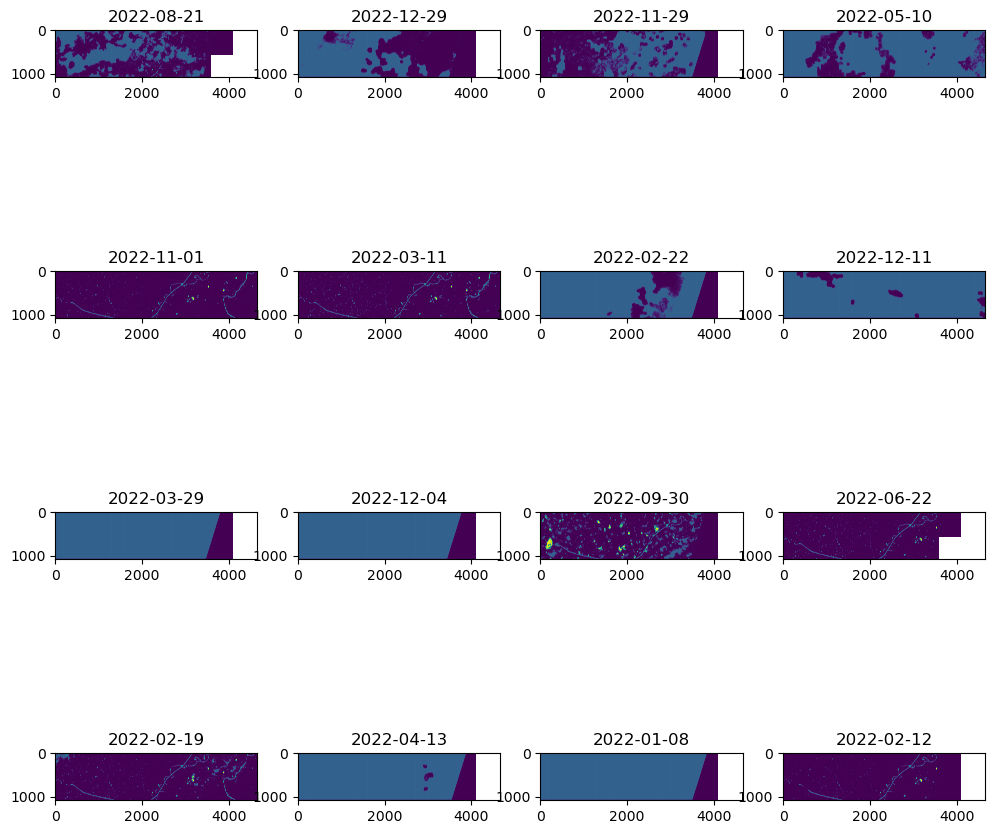

In [12]:
# random selection of results
nc = 4
fig, ax = plt.subplots(nc, nc, figsize=(3*nc, 3*nc))
for subax in ax.ravel():
    t = np.random.choice(ds.t.values)
    subax.imshow(ds["prediction"].sel(t=t).values, vmin=0, vmax=1)
    subax.set_title(pd.to_datetime(t).strftime("%Y-%m-%d"))

## Water detection based on Sentinel-2 & Sentinel-1

To run a U-Net requiring both Sentinel-2 and Sentinel-1 input, we need to first temporally align both. This is done within the UDF: for each S-2 scene, the closest S-1 scene that has less nan values than all candidates is selected.

We will first extract the dates on which S-1 and S-2 scenes are available, so we can pass this info to the UDF. As we need access to more than just 1 date value to be able to select the closest S-1 scene, we will pass the full datacube to the UDF (size for t dimension undefined), and make the UDF return the full S-2 time series.

In [14]:
# Tiny AOI for testing (temporary)
aoi_bounds = [513270, 5644200, 517690, 5647900] #[466800, 5616100, 603400, 5693900]
crs_epsg = 32631

spatial_extent = dict(zip(["west", "south", "east", "north"], aoi_bounds)) # box(*aoi_bounds).buffer(-30000).bounds)
spatial_extent["crs"] = crs_epsg

In [15]:
# Model
path_model = "/data/users/Public/landuytl/water-detection/PS120_2100-SY-FW0.9_MOP0.005_MOT0.80_S0_C1_2100_S2-6B-S1_D3_F32_W-E_A0_fromscratch_best.h5"

In [16]:
# Define bands in alignment with model inputs
bands_s2 = ["B02", "B03", "B04", "B08", "B11", "B12", "SCL"]
bands_s1 = ["VV", "VH"]

In [17]:
# Load datacube

# Get all S2 data
input_data_s2 = connection.load_collection(
    "TERRASCOPE_S2_TOC_V2",
    temporal_extent=[startdate, enddate],
    spatial_extent=spatial_extent,
    bands=bands_s2,
)

# Get all S1 data
input_data_s1 = connection.load_collection(
    "SENTINEL1_GRD_SIGMA0",
    temporal_extent=[startdate, enddate],
    spatial_extent=spatial_extent,
    bands=bands_s1,
)

input_data = input_data_s2.merge_cubes(input_data_s1)

In [18]:
# Get S-1 & S-2 dates to pass as input to UDF
# input_data_s2.dimension_labels("t").download("dates_s2.json")
# input_data_s1.dimension_labels("t").download("dates_s1.json")
s1_dates = input_data_s1.dimension_labels("t").execute()
s2_dates = input_data_s2.dimension_labels("t").execute()

In [19]:
# Apply model on openeo server

segmentationband = input_data.apply_neighborhood(
    lambda data: data.run_udf(udf=Path('unet_s1s2_timerange.py').read_text(), 
                              runtime='Python', 
                              context={"path_model": path_model,
                                      "s2_dates": s2_dates,
                                      "s1_dates": s1_dates}),
    size=[
        {'dimension': 'x', 'value': 100, 'unit': 'px'},
        {'dimension': 'y', 'value': 100, 'unit': 'px'}
    ],
    overlap=[
        {'dimension': 'x', 'value': 10, 'unit': 'px'},
        {'dimension': 'y', 'value': 10, 'unit': 'px'}
    ]
)

segmentationband = segmentationband.rename_labels(dimension="bands", target=["prediction"] + [""] * (len(bands_s2)+len(bands_s1)-1))
segmentationband = segmentationband.filter_bands(["prediction"])

In [20]:
# Submit job

job_options = {
    "executor-memory": "3G",
    "executor-memoryOverhead": "10G",
    "executor-cores": "1"
}

title="UNet_S1S2_{}_{}_{}".format(aoi_name, startdate, enddate)
job = segmentationband.create_job(out_format="NetCDF", title=title, job_options=job_options)
job.start_job()

# outputfile = "{}.nc".format(title)
# %time result = segmentationband.execute_batch(outputfile=outputfile, job_options=job_options) # to run instantly within notebook

In [21]:
# Follow up job status
connection.list_jobs()

[{'costs': 23.0,
  'created': '2023-06-23T09:20:53Z',
  'id': 'j-c01cf6d6d66648f5b5fb8045cd715656',
  'status': 'finished',
  'title': 'UNet_S1S2_EastFlandersSmall_2022-05-01_2022-06-01',
  'updated': '2023-06-23T09:21:12Z'},
 {'costs': 486.0,
  'created': '2023-06-19T12:31:34Z',
  'id': 'j-b8ff98caae114790a641afdab3d57c3d',
  'status': 'error',
  'title': 'UNet_S2_Treviso_2022-01-01_2023-01-01',
  'updated': '2023-06-19T12:31:57Z'},
 {'costs': 52.0,
  'created': '2023-06-21T13:42:59Z',
  'id': 'j-2d0eb560183c4ca58b2a2895238bdcd2',
  'status': 'error',
  'title': 'UNet_S1S2_EastFlandersSmall_2022-05-01_2022-06-01',
  'updated': '2023-06-21T13:43:19Z'},
 {'costs': 9.0,
  'created': '2023-06-20T08:48:39Z',
  'id': 'j-98778ccdfdf947959712ca3e7ce7dc1a',
  'status': 'error',
  'updated': '2023-06-20T08:48:56Z'},
 {'costs': 65.0,
  'created': '2023-06-21T15:00:13Z',
  'id': 'j-eda9de43a7f54c80a488fde5082d9e2e',
  'status': 'error',
  'title': 'UNet_S1S2_EastFlandersSmall_2022-05-01_2022-06-01',
  'updated': '2023-06-21T15:00:30Z'},
 {'costs': 1692.0,
  'created': '2023-06-19T16:45:20Z',
  'id': 'j-47673edec3104751a2764aa76d257f42',
  'status': 'finished',
  'title': 'UNet_S2_EastFlandersSmall_2022-01-01_2023-01-01',
  'updated': '2023-06-19T16:45:37Z'},
 {'costs': 10.0,
  'created': '2023-06-20T09:11:13Z',
  'id': 'j-e3a16c8137af4110af9e5f71d2d71853',
  'status': 'error',
  'updated': '2023-06-20T09:11:32Z'},
 {'costs': 45.0,
  'created': '2023-06-20T11:10:41Z',
  'id': 'j-517e6eb1fdc44c50b484e4bce02a29d5',
  'status': 'error',
  'title': 'UNet_S1S2_EastFlandersSmall_2022-05-01_2022-06-01',
  'updated': '2023-06-20T11:10:59Z'},
 {'costs': 104.0,
  'created': '2023-06-21T15:01:04Z',
  'id': 'j-01267487fae44d93874c65bbf7fbf95c',
  'status': 'finished',
  'title': 'UNet_S2_EastFlandersSmall_2022-05-01_2022-06-01',
  'updated': '2023-06-21T15:01:20Z'},
 {'costs': 10.0,
  'created': '2023-06-20T09:01:35Z',
  'id': 'j-aa213267a4a54c9ba69e546569d10574',
  'status': 'error',
  'updated': '2023-06-20T09:02:01Z'},
 {'costs': 58.0,
  'created': '2023-06-21T14:38:04Z',
  'id': 'j-89ace960d7ec4858b2a0b81d464e3033',
  'status': 'error',
  'title': 'UNet_S1S2_EastFlandersSmall_2022-05-01_2022-06-01',
  'updated': '2023-06-21T14:38:24Z'},
 {'costs': 10.0,
  'created': '2023-06-19T16:56:24Z',
  'id': 'j-feb23cca126a488da7542641bb63a0f4',
  'status': 'error',
  'updated': '2023-06-19T16:56:44Z'},
 {'costs': 29.0,
  'created': '2023-06-20T11:37:28Z',
  'id': 'j-3283ed76370443ba853b302528732421',
  'status': 'error',
  'title': 'UNet_S1S2_EastFlandersSmall_2022-05-01_2022-06-01',
  'updated': '2023-06-20T11:37:51Z'},
 {'costs': 8.0,
  'created': '2023-06-20T09:36:31Z',
  'id': 'j-e5cd1394b87446528b8224aaa9bee265',
  'status': 'error',
  'updated': '2023-06-20T09:36:50Z'}]

In [27]:
# Download result
path_result = download_job_result(connection.job("j-b8e6abf0ff0745dca767925436d14420"), os.getcwd(), fformat="nc")

INFO:openeo.rest.job:Downloading Job result asset 'openEO.nc' from https://openeo.vito.be/openeo/1.1/jobs/j-b8e6abf0ff0745dca767925436d14420/results/assets/ZGJiODBiOTA2NTIzODg3YzRmOTdjZjA5ODVmMWYxN2E1OTQ5OTk5MDA0M2NkNTg4NjlmODBmZjMyMTBlYTVlNUBlZ2kuZXU%3D/a7246df5f8c4a115e688e84a8a77113d/openEO.nc?expires=1679915527 to /projects/TAP/handson_sessions/water-detection/UNet_S1S2_UkraineSmall_2022-08-01_2022-09-01.nc


2023-03-20 12:12:07.471425 - Downloading /projects/TAP/handson_sessions/water-detection/UNet_S1S2_UkraineSmall_2022-08-01_2022-09-01.nc
	Download finished after 5 sec.


In [28]:
# Investigate result
ds = xr.open_dataset(path_result)
ds

<xarray.Dataset>
Dimensions:     (t: 13, x: 1230, y: 460)
Coordinates:
  * t           (t) datetime64[ns] 2022-08-02 2022-08-04 ... 2022-09-01
  * x           (x) float64 5.293e+05 5.293e+05 ... 5.416e+05 5.416e+05
  * y           (y) float64 5.303e+06 5.303e+06 ... 5.298e+06 5.298e+06
Data variables:
    crs         |S1 ...
    prediction  (t, y, x) float64 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform - Geotrellis backend: 0.9.4a1
    description:  
    title:

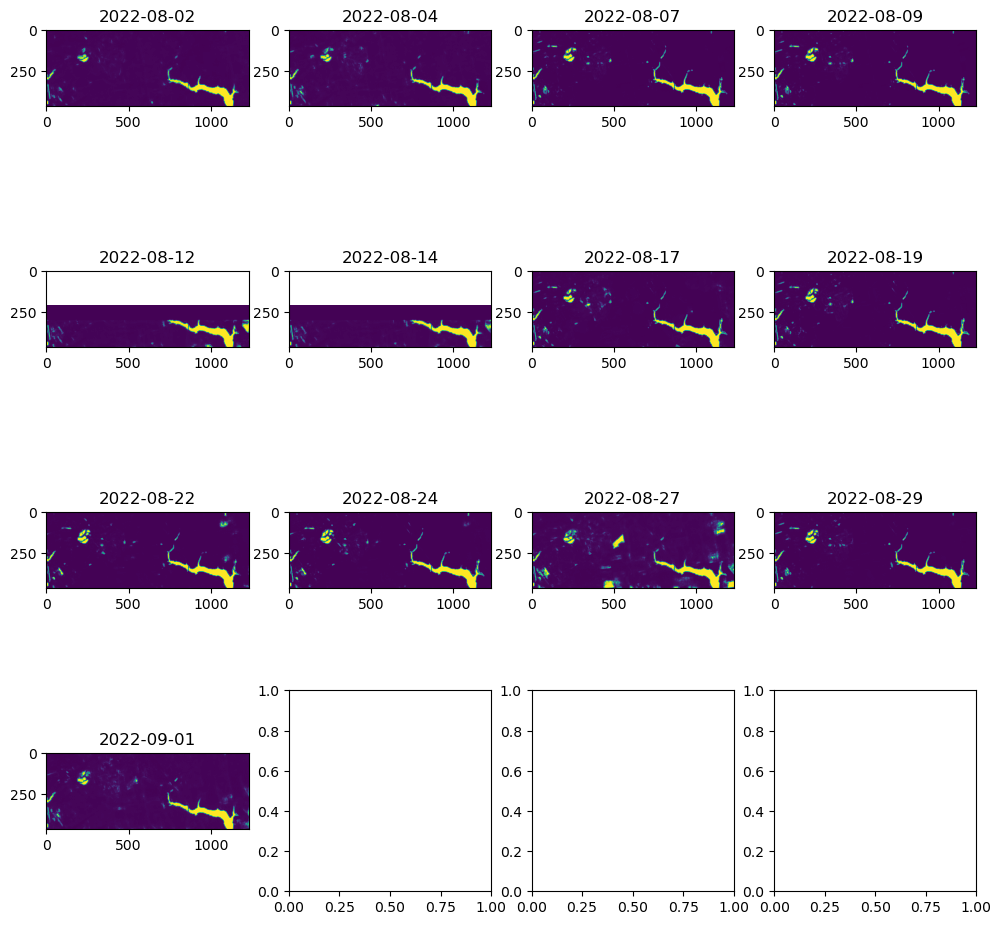

In [46]:
nc = int(np.ceil(np.sqrt(len(ds.t.values))))
fig, ax = plt.subplots(nc, nc, figsize=(3*nc, 3*nc))
for t, subax in zip(ds.t.values, ax.ravel()):
    subax.imshow(ds["prediction"].sel(t=t), vmin=0, vmax=1)
    subax.set_title(pd.to_datetime(t).strftime("%Y-%m-%d"))

## Local UDF debugging

For local debugging, these are the steps to follow:
- Download the dataset
- Save a subset that is the same size as the neighborhood
- Run execute_local_udf (make sure path to UDF is defined, and is accessible)
- Inspect the result

In [38]:
path_testinput = 'unet-s1-s2_test-input.nc'
path_testsubset = "unet-s1-s2_test-subset.nc"

In [39]:
# Download test dataset
input_data.download(path_testinput, format='NetCDF')

In [ ]:
# Inspect test data
ds_test = xr.open_dataset(path_testinput)

fig, ax = plt.subplots()
ax.imshow(make_plotting_array(ds_test[["B04", "B03", "B02"]].sel(t=ds_subset.t.values[0]).to_array().transpose("y", "x", "variable")))
plt.show()

ds_test

In [4]:
# Save test subset for local debugging
ds_subset = ds_test.sel(x=ds_test.x.values[400:520], y=ds_test.y.values[400:520]) # select ranges based on visual inspection
if os.path.exists(path_testsubset):
    os.remove(path_testsubset)
ds_subset.to_netcdf(path_testsubset)

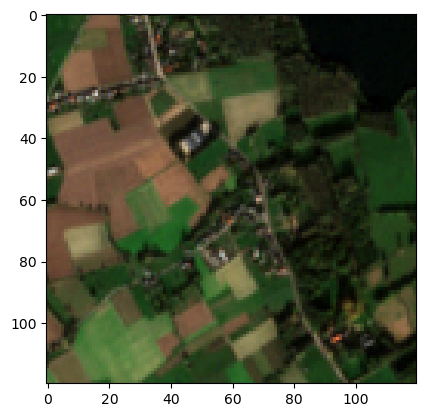

<xarray.Dataset>
Dimensions:  (t: 18, x: 120, y: 120)
Coordinates:
  * t        (t) datetime64[ns] 2022-11-01 2022-11-03 ... 2022-11-27 2022-12-01
  * x        (x) float64 6.007e+05 6.008e+05 6.008e+05 ... 6.019e+05 6.019e+05
  * y        (y) float64 5.651e+06 5.651e+06 5.651e+06 ... 5.65e+06 5.65e+06
Data variables:
    crs      |S1 ...
    B02      (t, y, x) float32 ...
    B03      (t, y, x) float32 ...
    B04      (t, y, x) float32 ...
    B08      (t, y, x) float32 ...
    B11      (t, y, x) float32 ...
    B12      (t, y, x) float32 ...
    SCL      (t, y, x) float32 ...
    VV       (t, y, x) float32 ...
    VH       (t, y, x) float32 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

In [5]:
# Inspect subset 
ds_subset = xr.open_dataset(path_testsubset)

fig, ax = plt.subplots()
ax.imshow(make_plotting_array(ds_subset[["B04", "B03", "B02"]].sel(t=ds_subset.t.values[0]).to_array().transpose("y", "x", "variable")))
plt.show()

ds_subset

In [14]:
# Apply model locally
from openeo.udf.run_code import execute_local_udf

udf = Path("unet_s1s2_timerange.py").read_text()
ds_res = execute_local_udf(udf, path_testsubset, fmt="netcdf")

INFO:openeo.udf.run_code:Found datacube mapping UDF `apply_datacube` <function apply_datacube at 0x7f36483ab5f0>
INFO:openeo.udf.debug.user:path_model from default: True
INFO:openeo.udf.debug.user:s2_dates from default: DatetimeIndex(['2022-11-01 00:00:00+00:00', '2022-11-06 00:00:00+00:00',
               '2022-11-13 00:00:00+00:00', '2022-11-16 00:00:00+00:00',
               '2022-11-18 00:00:00+00:00', '2022-11-23 00:00:00+00:00',
               '2022-11-26 00:00:00+00:00', '2022-12-01 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)
INFO:openeo.udf.debug.user:s1_dates from default: DatetimeIndex(['2022-11-03 00:00:00+00:00', '2022-11-07 00:00:00+00:00',
               '2022-11-10 00:00:00+00:00', '2022-11-12 00:00:00+00:00',
               '2022-11-15 00:00:00+00:00', '2022-11-19 00:00:00+00:00',
               '2022-11-22 00:00:00+00:00', '2022-11-24 00:00:00+00:00',
               '2022-11-27 00:00:00+00:00', '2022-12-01 00:00:00+00:00'],
              dty

<class 'numpy.ndarray'> (8, 120, 120)
<class 'numpy.ndarray'> (8, 120, 120)
<class 'numpy.ndarray'> (2, 8, 120, 120)


In [25]:
# Investigate results
ds_test = xr.open_dataset(path_testsubset)

res_array = ds_res.get_datacube_list()[0].get_array()
print(res_array.sizes)

Frozen({'t': 9, 'bands': 1, 'y': 120, 'x': 120})


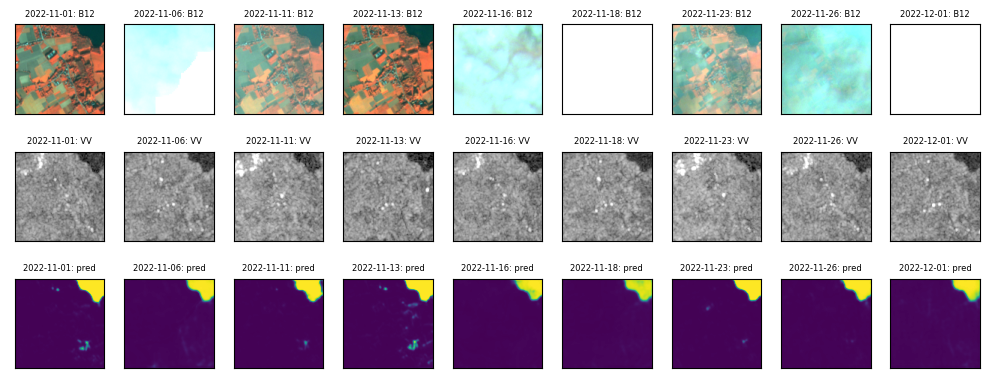

In [28]:
s2_date_indices = np.where(ds_test["B02"].notnull().sum(dim=["x", "y"]) > 0)[0]
s1_date_indices = np.where(ds_test["VV"].notnull().sum(dim=["x", "y"]) > 0)[0]

patch_size = ds_test.sizes["x"]

## calculate valid px count for S-1
s1_validpx_count = ds_test["VV"].notnull().sum(dim=["x", "y"]).values[s1_date_indices] # number of valid pixels per timestamp

fig, ax = plt.subplots(3, len(s2_date_indices), figsize=(10, 4))
for i_s2, i_t_s2 in enumerate(s2_date_indices):
    datetag = pd.to_datetime(str(ds_test.t.values[i_t_s2])).strftime("%Y-%m-%d")
    ## find matching S-1 scene
    time_differences = np.array([(el - ds_test.t.values[i_t_s2]) / np.timedelta64(1, "D") for el in ds_test.t.values[s1_date_indices]]) # unit: days
    i_s1 = np.random.choice(np.where(abs(time_differences) == np.min(abs(time_differences[s1_validpx_count >= 0.9 * patch_size**2])))[0])
    i_t_s1 = s1_date_indices[i_s1]

    ax[0, i_s2].imshow(np.moveaxis(np.array([scale_sentinel(ds_test[b].isel(t=i_t_s2).values.copy(), b, 0, 1) for b in ["B08", "B03", "B02"]]), 0, -1), vmin=-1, vmax=1, cmap="gray")
    ax[0, i_s2].set_title("{}: B12".format(datetag), fontsize=6)
    ax[1, i_s2].imshow(scale_sentinel(ds_test["VV"].isel(t=i_t_s1).values.copy(), "VV"), vmin=-1, vmax=1, cmap="gray")
    ax[1, i_s2].set_title("{}: VV".format(datetag), fontsize=6)
    ax[2, i_s2].imshow(res_array[i_s2, 0, :, :], vmin=0, vmax=1)
    ax[2, i_s2].set_title("{}: pred".format(datetag), fontsize=6)
for subax in ax.ravel():
    subax.set_xticks([])
    subax.set_yticks([])
plt.tight_layout()